# Learner class (Mnist Dataset)

In this notebook I will use SGD to optimize a model able to classify digits in public dataset (MNIST).
Also, I will create my own implementation of fastai Learner class. 

# Import fastai
This will give me access to some pytorch functions that I will use.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.5MB/s 
     |████████████████████████████████| 194kB 20.6MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 18.9MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 12.8MB 236kB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

## Getting the data

In [4]:
from google.colab import files

In [5]:
files.upload()

Saving mnist-original.mat to mnist-original.mat


In [41]:
from scipy.io import loadmat
mnist = loadmat("mnist-original.mat")
data = mnist["data"].T
label = mnist["label"][0]

Let's look at the shape of data and label and some examples to check what kind of data I am going to work with.

In [42]:
data.shape, label.shape

((70000, 784), (70000,))

In [43]:
28*28

784

Okey, so it seems that data is composed by 28*28 images with all the pixels combined into a single numpy array.

In [44]:
data[69990]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0

All pixels of the images are numbers between 0 and 255. I will convert them to floating point numbers between 0 and 1.

In [45]:
data = [data[i]/255 for i in range(len(data))]

Now I will check the labels.

In [46]:
label[69990]

9.0

Let's visualize the example before in a more user friendly way.

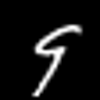

In [47]:
Image.fromarray((data[69990]*255).astype("uint8").reshape((28,28))).resize((100,100))

To be able to make the neural network I will transform each array into a tensor.

And each label into an integer.
<!-- and each label into a hot encoded vector (this will allow me to make a nice loss function). -->

In [48]:
data = [tensor(data[i]) for i in range(len(data))]

In [49]:
label = [int(label[i]) for i in range(len(label))]

## Creating the Dataloaders

### Datasets

First, I will create a dataset (something that if I index on it I will get a pair of a dependent and independent variable) and split into train and validation sets.

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
dset = list(zip(data,label))

In [52]:
train_dset, valid_dset = train_test_split(dset, test_size = 0.15, random_state = 999)

In [53]:
len(train_dset), len(valid_dset)

(59500, 10500)

### Dataloader

Then I will pass the datasets to a DataLoader object, which basically combines them into groups (mini-batchs) of certain size (batch_size) randomly (shuffle=True) to pass them at the same time to the GPU.

In [54]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

### Dataloaders
Now I will combine the training and validation dataloaders into a DataLoaders object.

In [55]:
dls = DataLoaders(train_dl, valid_dl)

Before starting to work with the Dataloaders I will use some samples of the train dataset to create a model, a loss function and a metric.

# Model
Because my independent variable are 28\*28 numbers and my dependent variable is an integer from 0 to 9, I will create a simple linear model using pytorch class nn.Linear with 28\*28 inputs and 10 outputs.

In [56]:
model0 = nn.Linear(28*28, 10)

I will extract one independent and its dependet variable.

In [57]:
x0 = train_dset[0][0]
y0 = train_dset[0][1]
y0

0

So the model outputs a tensor of length ten.

In [58]:
pred0 = model0(x0)
pred0

tensor([ 0.3654,  0.0556, -0.0160, -0.4832, -0.0369, -0.0733,  0.0502,  0.1787,  0.0399, -0.3788], grad_fn=<AddBackward0>)

Because the parameters of nn.Linear are initialized randomly this results doesn't mean anything, but I can start adjusting the parameters to make the result what I want.

# Loss function and metric
To adjust the parameters I will create a loss function that will allow me to check how far I am from the correct predictions to adjust the parameters based on this. Also, I will create a metric, which is basically the score that I care about.


## Loss function
The loss function should change for every small change that I will make to the parameters (weights), so I can calculate the gradients of the parameters based on this function and then change the parameters using the gradients to minimize it.

I want my vector of predictions to be numbers between 0 and 1 that add up to 1, so I will use softmax  for this.

I will get a subset of the data to do some tests.

In [59]:
b0 = [train_dset[i] for i in [1,1000,10000,20000,40000]]
y0 = tensor([b0[i][1] for i in range(len(b0))])
y0

tensor([7, 7, 1, 0, 7])

Let`s get some random predictions.

In [60]:
preds0 = [model0(b0[i][0]) for i in range(len(b0))]
preds0 = torch.reshape(torch.cat(preds0), [5, 10])
preds0

tensor([[ 0.0300,  0.1283, -0.3694, -0.4504,  0.1765,  0.0037,  0.2613, -0.0500, -0.1676, -0.1789],
        [ 0.0719,  0.2860, -0.4811, -0.1513, -0.0363, -0.1496,  0.2098, -0.0237,  0.0428, -0.0260],
        [ 0.0566,  0.1351,  0.1062, -0.0830, -0.3586,  0.2543, -0.0774, -0.0118,  0.1909, -0.1278],
        [ 0.5476,  0.1255, -0.0127, -0.0042, -0.0626,  0.2046,  0.1181,  0.1144,  0.1591,  0.1332],
        [ 0.1094, -0.0568,  0.1931, -0.1870, -0.1404,  0.0061, -0.0195,  0.0705, -0.1190, -0.0589]], grad_fn=<ViewBackward>)

Now I apply softmax to see the results.

In [61]:
preds0_sm = torch.softmax(preds0, dim=-1)
preds0_sm

tensor([[0.1071, 0.1181, 0.0718, 0.0662, 0.1240, 0.1043, 0.1349, 0.0988, 0.0879, 0.0869],
        [0.1081, 0.1340, 0.0622, 0.0865, 0.0970, 0.0867, 0.1241, 0.0983, 0.1050, 0.0981],
        [0.1035, 0.1119, 0.1087, 0.0900, 0.0683, 0.1261, 0.0905, 0.0966, 0.1183, 0.0860],
        [0.1494, 0.0980, 0.0853, 0.0860, 0.0812, 0.1060, 0.0972, 0.0969, 0.1013, 0.0987],
        [0.1131, 0.0958, 0.1230, 0.0841, 0.0881, 0.1020, 0.0994, 0.1088, 0.0900, 0.0956]], grad_fn=<SoftmaxBackward>)

From this vector, I will index to get the probability of the correct prediction and I will multiply this by -1. 

So the result will be smaller as the prediction for the correct target is bigger.

To do this I will use negative log likelihood.

In [62]:
idx = range(len(preds0_sm))
-preds0_sm[idx, y0]

tensor([-0.0988, -0.0983, -0.1119, -0.1494, -0.1088], grad_fn=<NegBackward>)

In [63]:
preds0_sm_nll = F.nll_loss(preds0_sm, y0, reduction='none')
preds0_sm_nll

tensor([-0.0988, -0.0983, -0.1119, -0.1494, -0.1088], grad_fn=<NllLossBackward>)

In nll_loss the logarithm wasn't apply. This is due to the fact that nll_loss assumes that you already applied the log because for computational reasons is better to do it before. 

The combination of this two methods in called Cross Entropy Loss (log_softmax + nll_loss). So I will directly use the function available for this in pytorch.

In [64]:
F.nll_loss(F.log_softmax(preds0), y0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(2.1887, grad_fn=<NllLossBackward>)

In [65]:
F.cross_entropy(preds0, y0)

tensor(2.1887, grad_fn=<NllLossBackward>)

## Metric
The metric will be something more interpretable like what percentage of the predictions are correct.

In this case I will use softmax again to make all the values between 0 and 1 and adding up to 1. Then I will select the index of the biggest value for each prediction tensor.

In [66]:
def mnist_accuracy(input, targets, axis=-1):
  sm = torch.softmax(input,dim=axis)
  preds = sm.argmax(dim=axis)
  return(preds==targets).float().mean()

In [67]:
mnist_accuracy(preds0, y0)

tensor(0.2000)

In [68]:
def epoch_accuracy(model, valid_data_loader):
  """Function that applies mnist_accuracy to every batch of
  the validation data laoder and take the mean"""
  return np.mean([mnist_accuracy(model(xb), yb) for xb,yb in valid_data_loader])


# Putting all together
Now I have the data, a model, a loss function and a metric. I will combine all this to create a trainning cycle.

Every batch I will adjust the parameters of the model based on the gradients of this parameters from the loss function (SGD).

In [69]:
print("Accuracy before training: ", epoch_accuracy(model0, valid_dl))

for xb,yb in train_dl:
  loss = F.cross_entropy(model0(xb), yb)
  loss.backward()
  for p in model0.parameters():
    # I will use a learning rate of 1
    p.data -= p.grad * 1
    p.grad.zero_()

print("Accuracy first epoch: ", epoch_accuracy(model0, valid_dl))

Accuracy before training:  0.11309524
Accuracy first epoch:  0.8966704


After just one epoch I go from around 13% accuracy on the validation set to around 90%.

I will predict one random item from the validation set and compare to its label.

In [70]:
sm = torch.softmax(model0(valid_dset[10000][0]),dim=-1)
sm.argmax(dim=-1), valid_dset[10000][1]

(tensor(9), 9)

This looks good!!

#Learner class
Lastly, I will create my own implementation of fastai Learner class, which will allow me to pass the data, model, etc and then use everything as a whole much easier.

In [71]:
class learner2():
  def __init__(self,dataloaders, model, opt_func, loss_func, metrics, lr=1):
    self.train = dataloaders[0]
    self.valid = dataloaders[1]
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metrics = metrics
    self.lr = lr
    self.opt = None
    self.loss = None
  
  def create_opt(self):
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
      
  def calc_grad(self, xb, yb):
    preds = self.model(xb)
    self.loss = self.loss_func(preds, yb)
    self.loss.backward()
      
  def validate_epoch(self):
    accs = [self.metrics(self.model(xb), yb) for xb,yb in self.valid]
    return round(torch.stack(accs).mean().item(), 4)
  
  def fit(self, epochs, lr=None):
    if lr:
      self.lr = lr
    if not self.opt: self.create_opt()
    for i in range(epochs):
      for xb,yb in self.train:
        self.calc_grad(xb, yb)
        self.opt.step()
        self.opt.zero_grad()
      print("Epoch ", i, " ", self.metrics.__name__, ":", self.validate_epoch(), end='\n')
  
  def predict(self, x):
    sm = torch.softmax(self.model(x),dim=-1)
    return sm.argmax(dim=-1)

In [72]:
learn0 = learner2(dls, nn.Linear(28*28, 10), opt_func=SGD, loss_func=F.cross_entropy, metrics=mnist_accuracy)

In [73]:
learn0.fit(10, lr=0.2)

Epoch  0   mnist_accuracy : 0.8906
Epoch  1   mnist_accuracy : 0.9047
Epoch  2   mnist_accuracy : 0.9041
Epoch  3   mnist_accuracy : 0.9124
Epoch  4   mnist_accuracy : 0.914
Epoch  5   mnist_accuracy : 0.9152
Epoch  6   mnist_accuracy : 0.9107
Epoch  7   mnist_accuracy : 0.9183
Epoch  8   mnist_accuracy : 0.9178
Epoch  9   mnist_accuracy : 0.9195


In [76]:
learn0.predict(valid_dset[5478][0]), valid_dset[5478][1]

(tensor(5), 5)

So with a simple linear model using SGD I was able to achieve a 92% accuracy on validation set. To finish I will use a little more complex model (I will add a ReLU as activation function to make it non-linear).
#Complex model

In [165]:
model1 = nn.Sequential(
    nn.Linear(28*28,50),
    nn.ReLU(),
    nn.Linear(50,10)
)

In [166]:
learn2 = learner2(dls, model1, opt_func=SGD, loss_func=F.cross_entropy, metrics=mnist_accuracy)

In [167]:
learn2.fit(20,lr=0.4)

Epoch  0   mnist_accuracy : 0.9181
Epoch  1   mnist_accuracy : 0.9414
Epoch  2   mnist_accuracy : 0.9433
Epoch  3   mnist_accuracy : 0.9554
Epoch  4   mnist_accuracy : 0.9612
Epoch  5   mnist_accuracy : 0.963
Epoch  6   mnist_accuracy : 0.9571
Epoch  7   mnist_accuracy : 0.9644
Epoch  8   mnist_accuracy : 0.966
Epoch  9   mnist_accuracy : 0.9653
Epoch  10   mnist_accuracy : 0.9698
Epoch  11   mnist_accuracy : 0.9637
Epoch  12   mnist_accuracy : 0.9707
Epoch  13   mnist_accuracy : 0.9709
Epoch  14   mnist_accuracy : 0.9717
Epoch  15   mnist_accuracy : 0.9674
Epoch  16   mnist_accuracy : 0.9643
Epoch  17   mnist_accuracy : 0.972
Epoch  18   mnist_accuracy : 0.973
Epoch  19   mnist_accuracy : 0.972


In [168]:
learn2.fit(15,lr=0.02)

Epoch  0   mnist_accuracy : 0.9705
Epoch  1   mnist_accuracy : 0.9717
Epoch  2   mnist_accuracy : 0.9713
Epoch  3   mnist_accuracy : 0.9734
Epoch  4   mnist_accuracy : 0.9682
Epoch  5   mnist_accuracy : 0.9741
Epoch  6   mnist_accuracy : 0.9719
Epoch  7   mnist_accuracy : 0.9727
Epoch  8   mnist_accuracy : 0.9677
Epoch  9   mnist_accuracy : 0.9747
Epoch  10   mnist_accuracy : 0.9739
Epoch  11   mnist_accuracy : 0.973
Epoch  12   mnist_accuracy : 0.9736
Epoch  13   mnist_accuracy : 0.9735
Epoch  14   mnist_accuracy : 0.9715


I achieved 97% accuracy with this!!

#Conclusion
With very basic pytorch functions, using SGD I was able to develop a model that classifies digits with 92 % accuracy. Adding one extra layer made the model more complex, but in this case allowed me to reach a 97% accuracy.

Also, I didn't spend much time tuning the learning rate or training the model, so with more time results could be even better.